In [1]:
import sys
import os

# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import torch
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ml_collections import ConfigDict
from scipy.interpolate import griddata, interp2d
from matplotlib.animation import FuncAnimation, PillowWriter

from nv_files.data_generator import solve_poisson_fft,compute_velocity,UniformSampler
from nv_files.Field_Generator import omega0_samples,omega0_samples_torch
from nv_files.NavierStokes import NavierStokes, Vorticity
#from nv_files.FEM_Solver import VorticitySolver
from nv_files.Pseudo_Spectral_Solver import VorticitySolver2D, torch_NVSolver2D
from nv_files.utilities import generate_noisy_obs,deepgala_data_fit
from Base.utilities import histogram_,stat_ar

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")    

# Inverse Problem

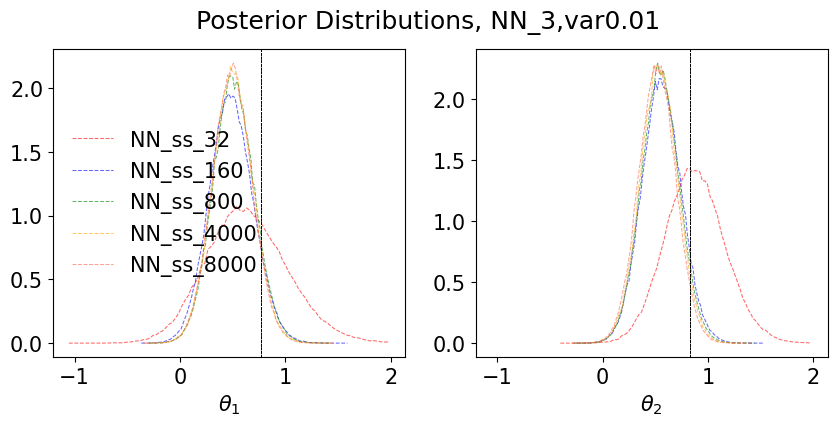

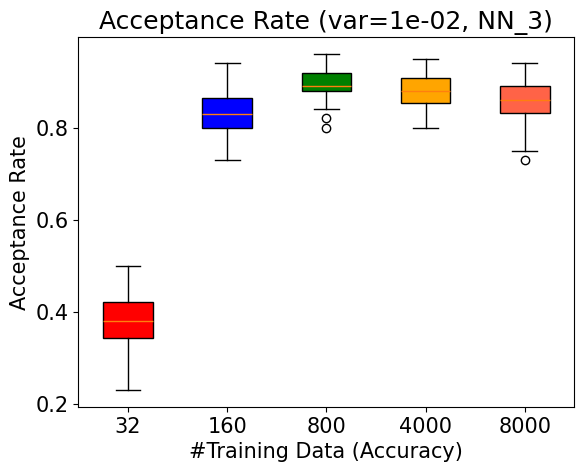

In [22]:
kl = 1
vr = 1e-2
hl = 3
nn = 300
N = [2,10,50,250,500]
cl = ["red", "blue", "green", "orange","tomato"]
plt.rcParams.update({'font.size': 15})

# Create subplots
fig, axs = plt.subplots(1, 2*kl, figsize=(10, 4), sharex=True)  # Adjust figsize for better visualization
fig.suptitle(f"Posterior Distributions, NN_{hl},var{vr}")

_, _, _,theta_t = generate_noisy_obs(obs=6,noise_level=vr, NKL = kl)

# Loop through each subplot
for i,(n,c) in enumerate(zip(N,cl)):
    samples = np.load(f'./results/nn_hl{hl}_n{nn}_s{n}_kl1_var{vr}.npy')
    for j in range(samples.shape[-1]):
        bin_centers, counts = histogram_(samples[:, j],bins=100)
        axs[j].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN_ss_{16*n}",color =c)
        axs[j].axvline(x = np.array(theta_t).flatten()[j], color = 'black',linestyle="--", linewidth=0.5)
        axs[j].set_xlabel(rf"$\theta_{j+1}$")
        #axs[j].set_xlim(-2,2)
    #axs[0].set_title(f"NN Model {i + 1}")

# Adjust layout
axs[0].legend(frameon = False)
#plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
plt.show()

fig.savefig(f"./results/images/nv_pd_hl{hl}_n{nn}_kl1_var{vr}.jpg")

acceptance_mean_list = np.array([stat_ar(np.load(f"./results/mcmc_da_nn_hl{hl}_n{nn}_s{n}_kl{kl}_var{vr}.npy"),every=100)[-1] for n in N])

bplot = plt.boxplot(acceptance_mean_list.T,patch_artist=True, labels=[str(n*16) for n in N])  # Transpose to plot along axis 1

# fill with colors
for patch, color in zip(bplot['boxes'], cl):
    patch.set_facecolor(color)

# Customize the plot
plt.title(f"Acceptance Rate (var={vr:.0e}, NN_{hl})")
plt.xlabel("#Training Data (Accuracy)")
plt.ylabel("Acceptance Rate")
#plt.ylim((0,0.5))
#plt.tight_layout()
# Save the plotx
plt.savefig(f"./results/images/nv_da_ar_hl{hl}_n{nn}_kl1_var{vr}.jpg")
plt.legend(frameon =False)
plt.show()

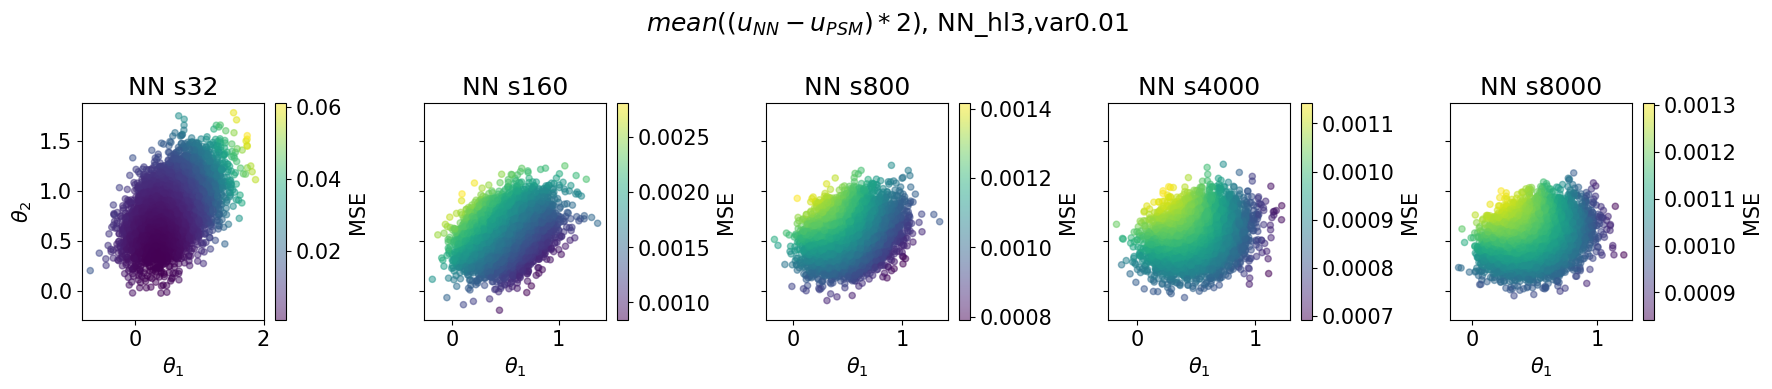

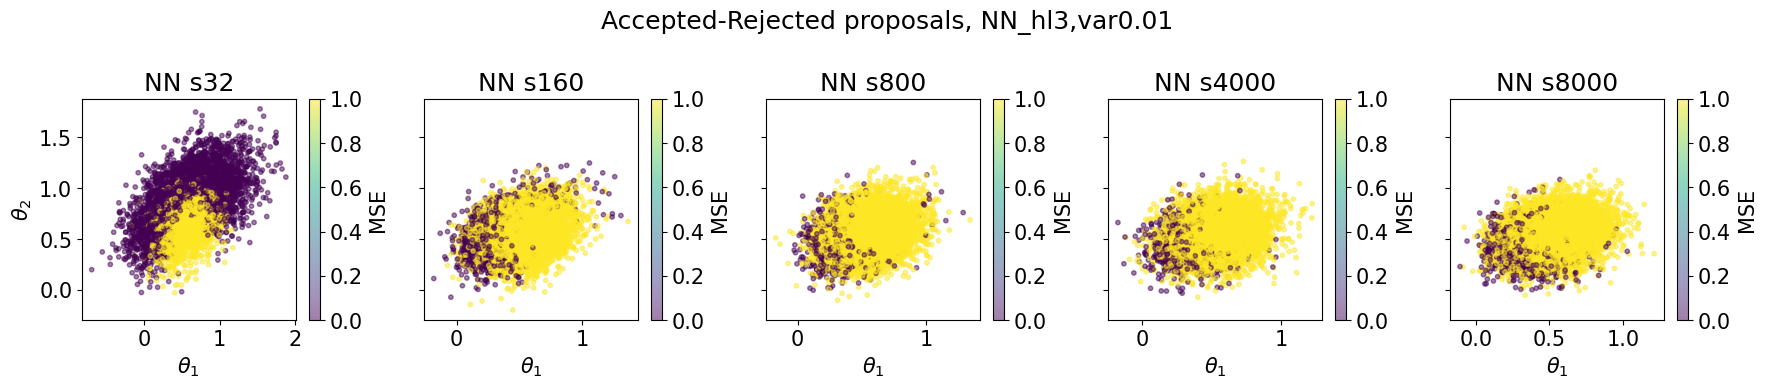

In [31]:
fig, axs = plt.subplots(1, len(N), figsize=(18, 4), sharey=True)  # Adjust figsize for better visualization

hl = 3
vr = 1e-2
for i,n in enumerate(N):
    fig.suptitle(fr"$mean((u_{{NN}} - u_{{PSM}})*2)$, NN_hl{hl},var{vr}")

    nn_res = np.load(f"./results/mcmc_da_nn_lh_nn_hl{hl}_n300_s{n}_kl1_var{vr}.npy")
    solver_res = np.load(f"./results/mcmc_da_nn_lh_solver_hl{hl}_n300_s{n}_kl1_var{vr}.npy")
    sampled_thetas = np.load(f"./results/mcmc_da_nn_proposal_thetas_hl{hl}_n300_s{n}_kl1_var{vr}.npy")

    error = np.mean((solver_res - nn_res)**2, axis=1).reshape(-1,1)

    error_theta = np.hstack([sampled_thetas,error])

    x = error_theta[:, 0]  # First column
    y = error_theta[:, 1]  # Second column
    z = error_theta[:, 2]  # Third column (for color/size)

    # Create a scatter plot
    scatter = axs[i].scatter(x, y, c=z, cmap='viridis', s=20, alpha=0.5)  # 'c' is for color, 's' is for size

    # Add color bar to represent the third column values
    cbar = fig.colorbar(scatter, ax=axs[i], label='MSE')
    # Labels and title
    axs[i].set_xlabel(rf"$\theta_{1}$")
    axs[i].set_title(f'NN s{n*16}')

# Add a single colorbar for all subplots (for consistency)
axs[0].set_ylabel(rf"$\theta_{2}$")
plt.tight_layout()  # Adjust layout to make sure there's no overlap

plt.savefig(f"./results/images/mse_hl{hl}_var{vr}.jpg")

fig, axs = plt.subplots(1, len(N), figsize=(18, 4), sharey=True)  # Adjust figsize for better visualization

for i,n in enumerate(N):
    fig.suptitle(fr"Accepted-Rejected proposals, NN_hl{hl},var{vr}")

    sampled_thetas = np.load(f"./results/mcmc_da_nn_proposal_thetas_hl{hl}_n300_s{n}_kl1_var{vr}.npy")
    acceted_thetas = np.load(f"./results/mcmc_da_nn_hl{hl}_n{300}_s{n}_kl{1}_var{vr}.npy").reshape(-1,1)

    error_theta = np.hstack([sampled_thetas,acceted_thetas])

    x = error_theta[:, 0]  # First column
    y = error_theta[:, 1]  # Second column
    z = error_theta[:, 2]  # Third column (for color/size)

    # Create a scatter plot
    scatter = axs[i].scatter(x, y, c=z, cmap='viridis', s=10, alpha=0.5)  # 'c' is for color, 's' is for size

    # Add color bar to represent the third column values
    cbar = fig.colorbar(scatter, ax=axs[i], label='MSE')
    # Labels and title
    axs[i].set_xlabel(rf"$\theta_{1}$")
    axs[i].set_title(f'NN s{n*16}')

# Add a single colorbar for all subplots (for consistency)
axs[0].set_ylabel(rf"$\theta_{2}$")
plt.tight_layout()  # Adjust layout to make sure there's no overlap

plt.savefig(f"./results/images/accep_reject_hl{hl}_var{vr}.jpg")


# Inverse Problem 

In [2]:
dim_obs = 128
NKL = 1

X = torch.linspace(0, 1, dim_obs)*2*torch.pi  # Spatial grid in X direction
Y = torch.linspace(0, 1, dim_obs)*2*torch.pi  # Spatial grid in Y direction
X, Y = torch.meshgrid(X, Y, indexing='ij' )  # Create meshgrid for X, Y

torch.manual_seed(42)  # Replace 42 with your desired seed value
np.random.seed(42)

# Generate uniformly distributed values for `theta` in the range [-1, 1]
theta = torch.rand(NKL, 2, 1) * 2 - 1  # Uniform(-1, 1)

w0 = omega0_samples_torch(X, Y, theta,d = 5,tau=np.sqrt(2))

def force_function(X, Y):
    return  (np.sin(X + Y) + np.cos(X + Y))

solver = VorticitySolver2D(N=dim_obs, L=2*np.pi, T=2.0, nu=1e-2, dt=5e-4,num_sol=100, method='CN',force = force_function)

obs_res = solver.run_simulation( np.array(w0[:,:,0]))

#rng = np.random.default_rng(42)
noise = np.random.normal(0, np.sqrt(1e-3), obs_res[-1].shape)

noisy_obs = obs_res[-1] + noise

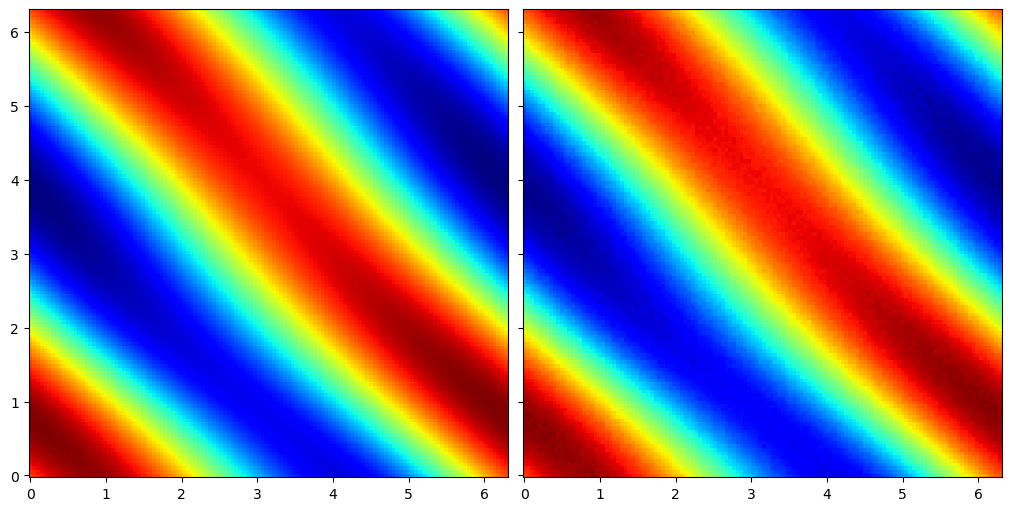

In [3]:
fig, axs = plt.subplots(1,2,figsize = (10,5), layout='constrained', sharey=True, sharex=True)

axs[0].pcolormesh(X, Y, obs_res[-1], cmap='jet')
axs[1].pcolormesh(X, Y, noisy_obs, cmap='jet')

In [4]:
def histogram_(x, bins=100):
    # Calculate histogram
    counts, bin_edges = np.histogram(x, bins=bins)

    # Normalize counts to form a probability density
    counts = counts / (sum(counts) * np.diff(bin_edges))

    # Calculate the bin centers for plotting
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return bin_centers, counts


class MetropolisHastingsSampler:
    """
    A class to perform Metropolis-Hastings sampling for parameter inference.
    It can use a neural network surrogate model or a numerical solver for likelihood evaluation.
    """

    def __init__(self, x, y, surrogate=None, nparam=2, sig=1.0, dt_init=0.5, reg=1e-3, device='cpu'):
        """
        Initialize the Metropolis-Hastings sampler.
        """
        self.device = device

        self.surrogate = surrogate
        self.x = torch.tensor(x, dtype=torch.float32, device=self.device)
        self.y = torch.tensor(y, dtype=torch.float32, device=self.device)
        self.sig = torch.tensor(sig, dtype=torch.float32, device=self.device)
        self.dt = torch.tensor(dt_init, dtype=torch.float32, device=self.device)
        self.reg = torch.tensor(reg,dtype=torch.float32, device=self.device)  # Regularization parameter

        self.nparam = nparam

        self.scaling_term = 1 / (2 + torch.sqrt(2 * torch.pi * self.reg)).to(self.device)  # Calculate once


    def log_prior_alpha(self, theta):
        """
        Log prior with Moreau-Yosida regularization for the uniform distribution between -1 and 1.
        """
        # Regularization term for all theta values
        regularization_term = -(torch.clamp(torch.abs(theta) - 1, min=0) ** 2) / (2 * self.reg)
        return torch.sum(regularization_term + torch.log(self.scaling_term))

    def proposals(self, alpha):
        """
        Generates proposals for the next step in the Metropolis-Hastings algorithm using a normal distribution.
        """
        # Generate normal proposals
        proposal = alpha + torch.normal(mean=torch.zeros_like(alpha), std=self.dt).to(self.device)
        
        return proposal

    def log_likelihood(self,pr):
        """
        Evaluates the log-likelihood given the surrogate model or numerical solver.
        """
        data_test = torch.cat([self.x, pr.repeat(self.x.size(0), 1)], dim=1)
        surg_mu = self.surrogate.w(data_test).detach()
        return -0.5 * torch.sum(((self.y - surg_mu) ** 2) / (self.sig ** 2))

        
    def log_posterior(self, pr):
        """
        Evaluates the log-posterior using the surrogate model.
        """
        return self.log_likelihood(pr) + self.log_prior_alpha(pr)

    def run_sampler(self, n_chains,alpha0 = None,verbose=True):
        """
        Run the Metropolis-Hastings sampling process sequentially.
        """
        # Initialize the parameters randomly within the prior range
        alpha = (torch.rand(self.nparam, device=self.device) * 2 - 1) if alpha0 == None else  alpha0
        alpha_samp = torch.zeros((n_chains, self.nparam), device=self.device)
        dt_tracker = torch.zeros(n_chains, device=self.device)
        acceptance_rate = 0

        for i in range(n_chains):
            # Propose new alpha values
            alpha_proposal = self.proposals(alpha)
            
            # Compute the current log-posterior
            log_posterior_current = self.log_posterior(alpha)
            log_posterior_proposal = self.log_posterior(alpha_proposal)

            # Compute the acceptance ratio
            a = torch.clamp(torch.exp(log_posterior_proposal - log_posterior_current), max=1.0)
            
            # Accept or reject the proposal
            if torch.rand(1, device=self.device) < a:
                alpha = alpha_proposal
                acceptance_rate += 1

            # Store the current sample and step size
            alpha_samp[i] = alpha
            dt_tracker[i] = self.dt

            # Adaptive step size adjustment 
            self.dt += self.dt * (a - 0.234) / (i + 1)

            del log_posterior_current, log_posterior_proposal, alpha_proposal
            if self.device != "cpu":
                torch.cuda.empty_cache()

            # Print progress every 10% of the steps
            if verbose and (i % (n_chains // 10)== 0 )and (n_chains != 0) :
                print(f"Iteration {i}, Acceptance Rate: {acceptance_rate / (i + 1):.4f}, Step Size: {self.dt:.4f}")

        if verbose:
            print(f"Final Acceptance Rate: {acceptance_rate / n_chains:.4f}")

        return alpha_samp.detach().cpu().numpy(), dt_tracker.detach().cpu().numpy()


In [5]:
class DAHM_NN:
    """
    A class to perform Metropolis-Hastings sampling for parameter inference.
    It can use a neural network surrogate model or a numerical solver for likelihood evaluation.
    """

    def __init__(self, x, y, nn_surrogate,indices_sol,N = 128, T=2,sigmat =5e-4 ,nparam=2, sig=1.0, 
                 dt_init=0.5, reg=1e-3, device='cpu'):
        """
        Initialize the Metropolis-Hastings sampler.
        """
        self.device = device

        self.x = torch.tensor(x, dtype=torch.float32, device=self.device)
        self.y = torch.tensor(y, dtype=torch.float32, device=self.device)
        self.sig = torch.tensor(sig, dtype=torch.float32, device=self.device)
        self.dt = torch.tensor(dt_init, dtype=torch.float32, device=self.device)
        self.reg = torch.tensor(reg,dtype=torch.float32, device=self.device)  # Regularization parameter

        self.nparam = nparam
        self.indices_sol = indices_sol

        # Initialize the FEMSolver once, if numerical solver is used
        X = torch.linspace(0, 1, N)*2*torch.pi  # Spatial grid in X direction
        Y = torch.linspace(0, 1, N)*2*torch.pi  # Spatial grid in Y direction
        X, Y = torch.meshgrid(X, Y,indexing="ij")  # Create meshgrid for X, Y

        self.X = X.to(device)
        self.Y = Y.to(device)

        self.solver = VorticitySolver2D(N=N, L=2*np.pi, T=T, nu=1e-2, 
                                       dt=sigmat,num_sol=2, method='CN', force= self.force_function)
        self.surrogate = nn_surrogate

        self.scaling_term = 1 / (2 + torch.sqrt(2 * torch.pi * self.reg)).to(self.device)  # Calculate once

    def force_function(self,X,Y):
        return  (np.sin(X + Y) + np.cos(X + Y))

    def log_prior_alpha(self, theta):
        """
        Log prior with Moreau-Yosida regularization for the uniform distribution between -1 and 1.
        """
        # Regularization term for all theta values
        regularization_term = -(torch.clamp(torch.abs(theta) - 1, min=0) ** 2) / (2 * self.reg)
        return torch.sum(regularization_term + torch.log(self.scaling_term))

    def proposals(self, alpha):
        """
        Generates proposals for the next step in the Metropolis-Hastings algorithm using a normal distribution.
    
        """
        # Generate normal proposals
        proposal = alpha + torch.normal(mean=torch.zeros_like(alpha), std=self.dt).to(self.device)
        
        return proposal

    def log_likelihood(self,pr):
        """
        Evaluates the log-likelihood given the numerical solver.
        """
        theta =  pr.reshape(1,-1).unsqueeze(-1) if self.nparam==2 else pr.reshape(-1,2).unsqueeze(-1)

        w0 = omega0_samples_torch(self.X, self.Y, theta, d=5, tau=np.sqrt(2))

        surg = self.solver.run_simulation(np.array(w0[:,:,0]))

        surg = torch.tensor(surg[-1], device=self.device).reshape(-1,1)
        surg = surg[self.indices_sol]

        return -0.5 * torch.sum(((self.y - surg) ** 2) / (self.sig ** 2))
    
    def nn_log_likelihood(self,pr):

        """
        Evaluates the log-likelihood given the surrogate model.
        """

        data = torch.cat([self.x, pr.repeat(self.x.size(0), 1)], dim=1)
        surg = self.surrogate.w(data).clone().detach()
        return -0.5 * torch.sum(((self.y - surg) ** 2) / (self.sig ** 2))

        
    def log_posterior(self,pr):
        """
        Evaluates the log-posterior using the numerical solver.
        """
        return self.log_likelihood(pr) + self.log_prior_alpha(pr)
    
    def nn_log_posterior(self,pr):
        """
        Evaluates the log-posterior using the numerical solver.
        """
        return self.nn_log_likelihood(pr) + self.log_prior_alpha(pr)

    def run_sampler(self,n_chains, alpha0 = None ,burn_in=100000, verbose=True):
        """
        Run the Metropolis-Hastings sampling process sequentially.
        """
        # Initialize the parameters randomly within the prior range
        alpha = (torch.rand(self.nparam, device=self.device) * 2 - 1) if alpha0 == None else  alpha0
        alpha_samp_inner = torch.zeros((n_chains, self.nparam), device=self.device)
        alpha_samp_inner = torch.zeros((n_chains, self.nparam), device=self.device)

        outer_mh = 0 
        for i in range(burn_in):
            # Propose new alpha values
            alpha_proposal = self.proposals(alpha)
            
            # Compute the current log-posterior
            log_posterior_current = self.nn_log_posterior(alpha)
            log_posterior_proposal = self.nn_log_posterior(alpha_proposal)

            # Compute the acceptance ratio
            a = torch.clamp(torch.exp(log_posterior_proposal - log_posterior_current), max=1.0)

            if torch.rand(1, device=self.device) < a:
                alpha = alpha_proposal.clone()
                outer_mh += 1

            # Adaptive step size adjustment 
            self.dt += self.dt * (a - 0.234) / (i + 1)

            if verbose and i % (burn_in // 10) == 0 and (i!=0):
                print(f"Burn-in {i}, Acceptance Rate: {outer_mh / (i+1):.4f}, Step Size: {self.dt:.4f}")

        print("Starting Delayed Acceptance....")

        inner_accepted,inner_mh = 0,0
        while inner_mh <= n_chains:
            # Propose new alpha values
            alpha_proposal = self.proposals(alpha)
            
            # Compute the current log-posterior
            log_posterior_current = self.nn_log_posterior(alpha)
            log_posterior_proposal = self.nn_log_posterior(alpha_proposal)

            # Compute the acceptance ratio
            a = torch.clamp(torch.exp(log_posterior_proposal - log_posterior_current), max=1.0)

            # Accept or reject the proposal
            if torch.rand(1, device=self.device) < a:
                inner_mh += 1
                log_posterior_current2 = self.log_posterior(alpha)
                log_posterior_proposal2 = self.log_posterior(alpha_proposal)

                # Compute the acceptance ratio
                a = torch.clamp(torch.exp(log_posterior_proposal2 - (log_posterior_current2))*(1/a), max=1.0)

                if torch.rand(1, device=self.device) < a:
                    alpha = alpha_proposal.clone()
                    inner_accepted += 1

            # Store the current sample and step size
            alpha_samp_inner[i] = alpha

            # Print progress every 10% of the steps
            if verbose and i % (n_chains // 10) == 0 and (i!=0):
                print(f"Iteration {i}, Acceptance Rate: {inner_accepted / inner_mh:.4f}, Step Size: {self.dt:.4f}")

        if verbose:
            print(f"Times inner step {inner_mh:.4f}, Acceptance Rate: {inner_accepted / inner_mh:.4f}")
            
        return inner_accepted / inner_mh, alpha_samp_inner.detach().cpu().numpy()

# MCMC Samples

In [ ]:

st = torch.sqrt(torch.tensor(1e-3,dtype=torch.float32)).to(device)
alpha0 = torch.tensor([0, 0.5])

obs_input_ = torch.cat((X.reshape(-1,1), Y.reshape(-1,1), 2*torch.ones_like(X.reshape(-1,1))), dim=1)
noisy_obs_ = noisy_obs.reshape(-1,1)

# Randomly select 10 unique row indices
indices = torch.randperm(noisy_obs_.shape[0])[:6]

# Sort the indices in ascending order
sorted_indices = indices.sort().values

obs_input = obs_input_[sorted_indices]
noisy_obs = noisy_obs_[sorted_indices]

tensor([[0.2968, 4.5516, 2.0000],
        [0.2968, 5.7390, 2.0000],
        [1.5337, 2.8695, 2.0000],
        [1.6326, 5.1453, 2.0000],
        [2.8200, 4.9969, 2.0000],
        [4.7000, 5.4421, 2.0000]]) [[-2.05877517]
 [ 1.24582858]
 [-2.35461038]
 [ 2.52934486]
 [ 2.05233504]
 [-2.74437344]]


In [ ]:
for i in range(1,5):
    print(f"Initializing MCMC with model {i}")
    nn_surrogate_model = torch.load(f"./models/vorticity_2_MDNN_dg_{i}.pth")
    nn_surrogate_model.eval()

    sampler = MetropolisHastingsSampler(surrogate=nn_surrogate_model,x = obs_input,y = noisy_obs,sig = st,dt_init=5e-3,nparam=4)
    mcmc_samples,_ = sampler.run_sampler(n_chains = 1000000)

    np.save(f'./results/MDNN_dg_2_smodel_{i}.npy', mcmc_samples)

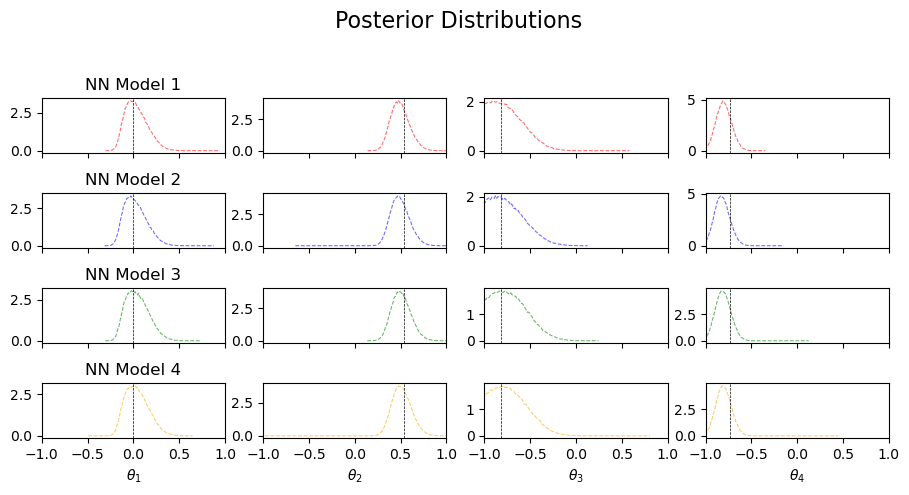

In [20]:
# Create subplots
fig, axs = plt.subplots(4, 4, figsize=(9, 5), sharex=True)  # Adjust figsize for better visualization
fig.suptitle("Posterior Distributions", fontsize=16)

cl = ["red", "blue", "green", "orange"]
# Loop through each subplot
for i,c in enumerate(cl):
    samples = np.load(f'./results/MDNN_dg_2_smodel_{i+1}.npy')
    for j in range(samples.shape[-1]):
        bin_centers, counts = histogram_(samples[:, j],bins=100)
        axs[i,j].plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = f"NN Model {i+1}",color =c)

        axs[i,j].axvline(x = np.array(theta).flatten()[j], color = 'black',linestyle="--", linewidth=0.5)
        axs[-1,j].set_xlabel(rf"$\theta_{j+1}$"),axs[-1,j].set_xlim(-1,1)
    axs[i,0].set_title(f"NN Model {i + 1}")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
plt.show()

# Delayed Acceptance Algorithm

In [8]:
acceptance_rate_list = []
for i in range(1,5):
    print(f"Initializing MCMC with model {i}")
    nn_surrogate_model = torch.load(f"./models/vorticity_2_MDNN_dg_{i}.pth")
    nn_surrogate_model.eval()
    nn_surrogate_model.to(device)

    mcmc_nn = DAHM_NN(obs_input,noisy_obs,nn_surrogate_model,indices_sol=sorted_indices,nparam=4, dt_init=5e-3,sig = st,device= device)
    ar,_ = mcmc_nn.run_sampler(burn_in=1000000,n_chains = 20000) 
    acceptance_rate_list.append(ar)

Initializing MCMC with model 1


/tmp/ipykernel_29766/3491199920.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x, dtype=torch.float32, device=self.device)
/tmp/ipykernel_29766/3491199920.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sig = torch.tensor(sig, dtype=torch.float32, device=self.device)


Burn-in 100000, Acceptance Rate: 0.2827, Step Size: 0.0726
Burn-in 200000, Acceptance Rate: 0.2718, Step Size: 0.0740
Burn-in 300000, Acceptance Rate: 0.2667, Step Size: 0.0746
Burn-in 400000, Acceptance Rate: 0.2638, Step Size: 0.0751
Burn-in 500000, Acceptance Rate: 0.2618, Step Size: 0.0754
Burn-in 600000, Acceptance Rate: 0.2603, Step Size: 0.0756
Burn-in 700000, Acceptance Rate: 0.2588, Step Size: 0.0758
Burn-in 800000, Acceptance Rate: 0.2575, Step Size: 0.0760
Burn-in 900000, Acceptance Rate: 0.2563, Step Size: 0.0760
Starting Delayed Acceptance....
Iteration 2000, Acceptance Rate: 0.6338, Step Size: 0.0762
Iteration 4000, Acceptance Rate: 0.6624, Step Size: 0.0762
Iteration 6000, Acceptance Rate: 0.6592, Step Size: 0.0762
Iteration 8000, Acceptance Rate: 0.6506, Step Size: 0.0762
Iteration 10000, Acceptance Rate: 0.6552, Step Size: 0.0762
Iteration 12000, Acceptance Rate: 0.6509, Step Size: 0.0762
Iteration 14000, Acceptance Rate: 0.6494, Step Size: 0.0762
Iteration 16000, Acce

KeyboardInterrupt: 

Text(0, 0.5, 'Acceptance Rate')

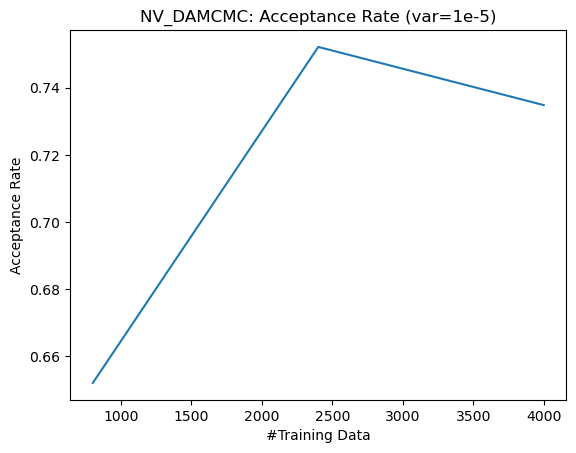

In [12]:
acceptance_rate_list

plt.plot([50*16,16*150,16*250],acceptance_rate_list)
plt.title("NV_DAMCMC: Acceptance Rate (var=1e-5)")
plt.xlabel("#Training Data")
plt.ylabel("Acceptance Rate")

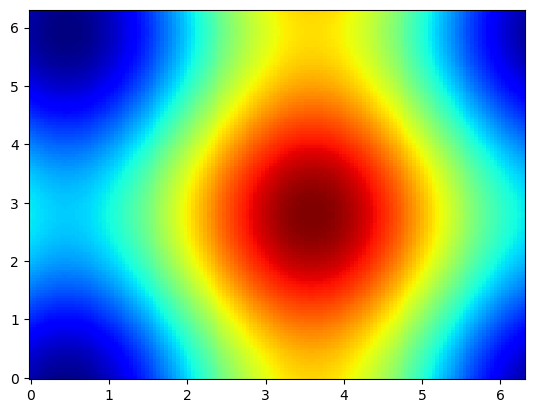

In [ ]:
w0 = omega0_samples_torch(X, Y, torch.tensor([[[-0.5015],[ 0.1819]],[[-0.9936],[-0.4855]]]),d = 5,tau=np.sqrt(2))
plt.pcolormesh(X, Y, w0[:,:,0], cmap='jet')


tensor([-0.5015,  0.1819, -0.9936, -0.4855])


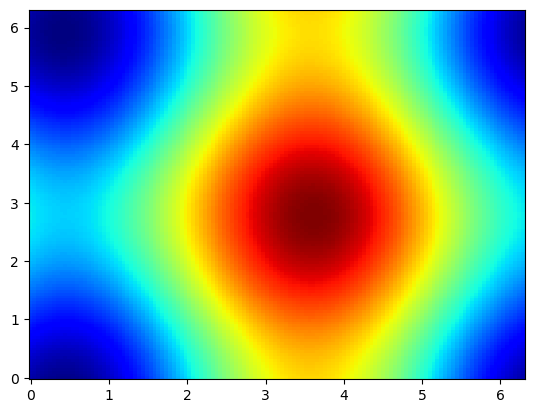

In [13]:
obs_input_ = torch.cat((X.reshape(-1,1), Y.reshape(-1,1), 2*torch.zeros_like(X.reshape(-1,1))), dim=1)

pr = torch.tensor([[[-0.5015],[ 0.1819]],[[-0.9936],[-0.4855]]]).flatten()
print(pr)
data = torch.cat([obs_input_, pr.repeat(obs_input_.size(0), 1)], dim=1)

res = nn_surrogate_model.w(data).detach().numpy()
w_pred_mdnn = griddata((X.reshape(-1), Y.reshape(-1)), res.flatten(), (X, Y), method='cubic')


plt.pcolormesh(X, Y, w_pred_mdnn, cmap='jet')


# MCMC

In [21]:
import pyro
import pyro.distributions as dist
import pyro.infer.mcmc as mcmc

In [ ]:
def nn_surrogate(surrogate,noisy_obs, valuation_inputs,sig  = np.sqrt(1e-3),device='cpu'):

    # Prior for the parameters theta (assuming 2 parameters)
    theta = pyro.sample("theta", dist.Uniform(-1, 1).expand([4]))

    data_test = torch.cat([valuation_inputs, theta.repeat(valuation_inputs.size(0), 1)], dim=1)

    surg_mu = surrogate.w(data_test)

    surg_mu = surg_mu.view(-1, 1)

    # Likelihood: Gaussian likelihood with a fixed standard deviation
    y = pyro.sample("obs", dist.Normal(surg_mu, sig).to_event(1), obs=torch.Tensor(noisy_obs).to(device))

    return y

In [45]:
obs_input_ = torch.cat((X.reshape(-1,1), Y.reshape(-1,1), 2*torch.ones_like(X.reshape(-1,1))), dim=1)
noisy_obs_ = noisy_obs.reshape(-1,1)

In [36]:
st = torch.sqrt(torch.tensor(1e-3,dtype=torch.float32)).to(device)

nn_surrogate_model = torch.load(f"./models/vorticity_MDNN_dg_2.pth")
nn_surrogate_model.eval()

kernel = mcmc.RandomWalkKernel(nn_surrogate, target_accept_prob=0.234)

mcmc_sampler = mcmc.MCMC(kernel, num_samples=500000, warmup_steps=500)

mcmc_sampler.run(nn_surrogate_model,noisy_obs,obs_input)

# Get the results (posterior samples)
samples = mcmc_sampler.get_samples()
samples = samples["theta"].numpy()

np.save(f'./results/MDNN_dg_samples_2.npy', samples)
del kernel, mcmc_sampler, samples

    #### Deep GaLA
    # data_int,left_bc,right_bc = generate_data(nobs, param = param_train)
    # data_int,left_bc,right_bc  = data_int.to(device),left_bc.to(device),right_bc.to(device)


    # pde = {"PDE":["de","bc_l","bc_r"], 
    #     "data_set":{"de" : Variable(data_int,requires_grad=True),
    #     "bc_l":left_bc,
    #     "bc_r" :right_bc}}
    
    # llp2 = llaplace2(model)

    # start_time_mh = time.time()  # Start timing
    # llp2.fit(pde=pde, hessian_structure = "full")
    # end_time_mh = time.time()  # End timing
    # print(f"Total time for fitting: {(end_time_mh-start_time_mh)/60 }")

    # start_time_mh = time.time()  # Start timing
    # llp2.optimize_marginal_likelihood()
    # end_time_mh = time.time()  # End timing
    # print(f"Total time for optimizing: {(end_time_mh-start_time_mh)/60 }")
    
    # kernel = mcmc.RandomWalkKernel(model_dgala, target_accept_prob=0.234)

    # mcmc_sampler = MCMC(kernel, num_samples=1000000, warmup_steps=5000)

    # mcmc_sampler.run(llp2,torch.tensor(obs_sol).float().to(device),
    #                  torch.tensor(obs_points).float().to(device),
    #                  torch.sqrt(torch.tensor(vr).float().to(device)))

    # # Get the results (posterior samples)
    # samples = mcmc_sampler.get_samples()
    # samples = samples["theta"].numpy()

    # np.save(f'./Models/dGaLA2_DNN_hl{2}_w{20}_var{vr}_{nobs}_Samples.npy', samples)
    # del kernel, mcmc_sampler, samples

Sample: 100%|██████████| 500500/500500 [57:02:49,  2.44it/s, step size=7.18e-02, acc. prob=0.000]


In [37]:
sample = np.load(f'./results/MDNN_dg_samples_1.npy')

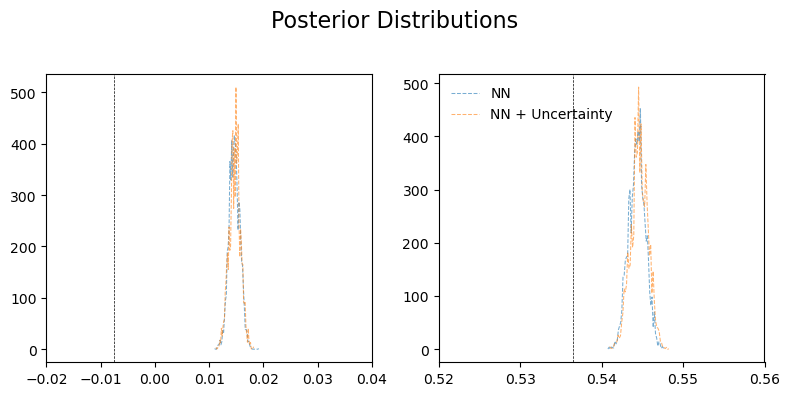

In [62]:
def histogram_(x, bins=100):
    # Calculate histogram
    counts, bin_edges = np.histogram(x, bins=bins)

    # Normalize counts to form a probability density
    counts = counts / (sum(counts) * np.diff(bin_edges))

    # Calculate the bin centers for plotting
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return bin_centers, counts

sample = np.load(f'./results/MDNN_dg_samples_1.npy')
sample1 = np.load(f'./results/lla_MDNN_dg_samples_1.npy')


# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 4))  # Adjust figsize for better visualization
fig.suptitle("Posterior Distributions", fontsize=16)

# Loop through each subplot
for idx, ax in enumerate(axs.flatten()):
    if idx < sample.shape[1]:  # Check to avoid indexing beyond data dimensions
        bin_centers, counts = histogram_(sample[:, idx],bins=50)
        ax.plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = "NN")

        bin_centers, counts = histogram_(sample1[:, idx],bins=50)
        ax.plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label= "NN + Uncertainty")

        ax.axvline(x = np.array(theta).flatten()[idx], color = 'black',linestyle="--", linewidth=0.5)
    else:
        ax.axis("off")  # Turn off axes for extra subplots
axs[0].set_xlim(-0.02,0.04)
axs[1].set_xlim(.52,.56)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
plt.legend(frameon = False)
plt.show()

In [32]:
class DAHM_NN:
    """
    A class to perform Metropolis-Hastings sampling for parameter inference.
    It can use a neural network surrogate model or a numerical solver for likelihood evaluation.
    """

    def __init__(self, x, y, nn_surrogate, chain,N = 128, T=1,sigmat =5e-4 ,nparam=2, sig=1.0, 
                 dt_init=0.5, reg=1e-3, device='cpu'):
        """
        Initialize the Metropolis-Hastings sampler.
        """
        self.device = device

        self.x = torch.tensor(x, dtype=torch.float32, device=self.device)
        self.y = torch.tensor(y, dtype=torch.float32, device=self.device)
        self.sig = torch.tensor(sig, dtype=torch.float32, device=self.device)
        self.dt = torch.tensor(dt_init, dtype=torch.float32, device=self.device)
        self.reg = torch.tensor(reg,dtype=torch.float32, device=self.device)  # Regularization parameter

        self.nparam = nparam
        self.chain = chain

        # Initialize the FEMSolver once, if numerical solver is used
        X = torch.linspace(0, 1, N)*2*torch.pi  # Spatial grid in X direction
        Y = torch.linspace(0, 1, N)*2*torch.pi  # Spatial grid in Y direction
        X, Y = torch.meshgrid(X, Y)  # Create meshgrid for X, Y

        self.X = X
        self.Y = Y

        self.solver = VorticitySolver2D(N=N, L=1, T=T, nu=1e-2, dt=sigmat,num_sol=2, method='CN', force= self.force_function)
        self.surrogate = nn_surrogate

        self.scaling_term = 1 / (2 + torch.sqrt(2 * torch.pi * self.reg)).to(self.device)  # Calculate once

    def force_function(self,X,Y):
        return  (np.sin(X + Y) + np.cos(X + Y))

    def log_prior_alpha(self, theta):
        """
        Log prior with Moreau-Yosida regularization for the uniform distribution between -1 and 1.
        """
        # Regularization term for all theta values
        regularization_term = -(torch.clamp(torch.abs(theta) - 1, min=0) ** 2) / (2 * self.reg)
        return torch.sum(regularization_term + torch.log(self.scaling_term))

    def proposals(self, alpha):
        """
        Generates proposals for the next step in the Metropolis-Hastings algorithm using a normal distribution.
    
        """
        # Generate normal proposals
        proposal = alpha + torch.normal(mean=torch.zeros_like(alpha), std=self.dt).to(self.device)
        
        return proposal

    def log_likelihood(self,pr):
        """
        Evaluates the log-likelihood given the numerical solver.
        """
        theta =  pr.reshape(1,-1).unsqueeze(-1)
        
        w0 = omega0_samples_torch(self.X, self.Y, theta, d=5, tau=np.sqrt(2))

        surg = self.solver.run_simulation(np.array(w0[:,:,0]))

        surg = torch.tensor(surg[-1], device=self.device).reshape(-1,1)

        return -0.5 * torch.sum(((self.y - surg) ** 2) / (self.sig ** 2))
    
    def nn_log_likelihood(self,pr):

        """
        Evaluates the log-likelihood given the surrogate model.
        """

        data = torch.cat([self.x, pr.repeat(self.x.size(0), 1)], dim=1)
        surg = self.surrogate.w(data).detach()
        return -0.5 * torch.sum(((self.y - surg) ** 2) / (self.sig ** 2))

        
    def log_posterior(self,pr):
        """
        Evaluates the log-posterior using the numerical solver.
        """
        return self.log_likelihood(pr) + self.log_prior_alpha(pr)
    
    def nn_log_posterior(self,pr):
        """
        Evaluates the log-posterior using the numerical solver.
        """
        return self.nn_log_likelihood(pr) + self.log_prior_alpha(pr)

    def run_sampler(self, verbose=True):
        """
        Run the Metropolis-Hastings sampling process sequentially.
        """
        n_chains = self.chain.shape[0]
        # Initialize the parameters randomly within the prior range
        alpha = torch.rand(self.nparam, device=self.device) * 2 - 1
        alpha_samp = torch.zeros((n_chains, self.nparam), device=self.device)
        #dt_tracker = torch.zeros(n_chains, device=self.device)
        acceptance_rate = 0
        inner_mh = 0

        for i in range(n_chains):
            # Propose new alpha values
            alpha_proposal = self.chain[i,:]
            
            # Compute the current log-posterior
            log_posterior_current = self.nn_log_posterior(alpha)
            log_posterior_proposal = self.nn_log_posterior(alpha_proposal)

            # Compute the acceptance ratio
            a = torch.clamp(torch.exp(log_posterior_proposal - log_posterior_current), max=1.0)

            # Accept or reject the proposal
            if torch.rand(1, device=self.device) < a:
                inner_mh += 1
                log_posterior_current2 = self.log_posterior(alpha)
                log_posterior_proposal2 = self.log_posterior(alpha_proposal)

                # Compute the acceptance ratio
                a = torch.clamp(torch.exp(log_posterior_proposal2 - (log_posterior_current2))*(1/a), max=1.0)

                if torch.rand(1, device=self.device) < a:
                    alpha = alpha_proposal.clone()
                    acceptance_rate += 1

            # Store the current sample and step size
            alpha_samp[i] = alpha
            #dt_tracker[i] = self.dt

            # Adaptive step size adjustment 
            #self.dt += self.dt * (a - 0.234) / (i + 1)

            del log_posterior_current, log_posterior_proposal, alpha_proposal
            if self.device != "cpu":
                torch.cuda.empty_cache()

            # Print progress every 10% of the steps
            if verbose and i % (n_chains // 10) == 0 and (i!=0):
                print(f"Iteration {i}, Acceptance Rate: {acceptance_rate / inner_mh:.3f}, Step Size: {self.dt:.4f}")
                #print(f"Iteration {i}, Acceptance Rate: {acceptance_rate / (i + 1):.3f}, Step Size: {self.dt:.4f}")

        # if verbose:
        #     print(f"Final Acceptance Rate: {acceptance_rate / n_chains:.3f}")
            
        return alpha_samp.detach().cpu().numpy()

In [58]:
st = np.sqrt(1e-3)

obs_input = torch.cat((X.reshape(-1,1), Y.reshape(-1,1), 2*torch.ones_like(X.reshape(-1,1))), dim=1)
noisy_obs = noisy_obs.reshape(-1,1)

nn_surrogate_model = torch.load(f"./models/vorticity_MDNN_dg_1.pth")
nn_surrogate_model.eval()

nnsamples = torch.tensor(np.load(f'./results/MDNN_dg_samples_1.npy'))
shape_samples = nnsamples.shape

mcmc_nn = DAHM_NN(obs_input,noisy_obs,nn_surrogate_model,nnsamples[400000:,:],sig = st)

samples = mcmc_nn.run_sampler() 

Iteration 10000, Acceptance Rate: 0.141, Step Size: 0.5000
Iteration 20000, Acceptance Rate: 0.071, Step Size: 0.5000
Iteration 30000, Acceptance Rate: 0.052, Step Size: 0.5000
Iteration 40000, Acceptance Rate: 0.045, Step Size: 0.5000
Iteration 50000, Acceptance Rate: 0.042, Step Size: 0.5000
Iteration 60000, Acceptance Rate: 0.036, Step Size: 0.5000
Iteration 70000, Acceptance Rate: 0.031, Step Size: 0.5000
Iteration 80000, Acceptance Rate: 0.028, Step Size: 0.5000
Iteration 90000, Acceptance Rate: 0.025, Step Size: 0.5000


In [59]:
np.save(f'./results/DA_nn_samples.npy', samples)

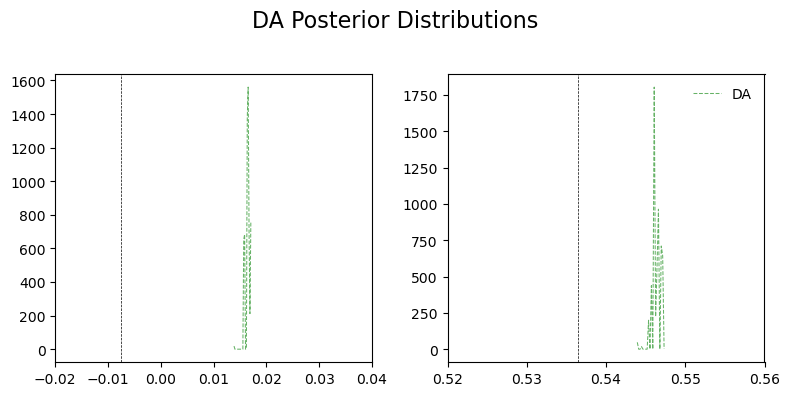

In [28]:
def histogram_(x, bins=100):
    # Calculate histogram
    counts, bin_edges = np.histogram(x, bins=bins)

    # Normalize counts to form a probability density
    counts = counts / (sum(counts) * np.diff(bin_edges))

    # Calculate the bin centers for plotting
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return bin_centers, counts

samples = np.load(f'./results/DA_nn_samples.npy')


# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 4))  # Adjust figsize for better visualization
fig.suptitle("DA Posterior Distributions", fontsize=16)

# Loop through each subplot
for idx, ax in enumerate(axs.flatten()):
    if idx < samples.shape[1]:  # Check to avoid indexing beyond data dimensions
        bin_centers, counts = histogram_(samples[:, idx],bins=20)
        ax.plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = "DA",color = "green")

        ax.axvline(x = np.array(theta).flatten()[idx], color = 'black',linestyle="--", linewidth=0.5)
    else:
        ax.axis("off")  # Turn off axes for extra subplots
axs[0].set_xlim(-0.02,0.04)
axs[1].set_xlim(.52,.56)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
plt.legend(frameon = False)
plt.show()

In [111]:
torch.manual_seed(42)

st = np.sqrt(1e-3)
alpha0 = torch.tensor([0, 0.5])

obs_input = torch.cat((X.reshape(-1,1), Y.reshape(-1,1), 2*torch.ones_like(X.reshape(-1,1))), dim=1)
noisy_obs = noisy_obs.reshape(-1,1)

# Randomly select 10 unique row indices
indices = torch.randperm(noisy_obs_.shape[0])[:6]

# Sort the indices in ascending order
sorted_indices = indices.sort().values

obs_input = obs_input_[sorted_indices]
noisy_obs = noisy_obs_[sorted_indices]

nn_surrogate_model = torch.load(f"./models/vorticity_MDNN_dg_1.pth")
nn_surrogate_model.eval()

mcmc_nn = DAHM_NN(obs_input,noisy_obs,nn_surrogate_model,indices_sol=sorted_indices, dt_init=5e-3,sig = st)

samples = mcmc_nn.run_sampler(alpha0 = alpha0,burn_in=1000000,n_chains = 20000) 

Burn-in 100000, Acceptance Rate: 0.2597, Step Size: 0.1070
Burn-in 200000, Acceptance Rate: 0.2548, Step Size: 0.1081
Burn-in 300000, Acceptance Rate: 0.2516, Step Size: 0.1086
Burn-in 400000, Acceptance Rate: 0.2494, Step Size: 0.1089
Burn-in 500000, Acceptance Rate: 0.2487, Step Size: 0.1092
Burn-in 600000, Acceptance Rate: 0.2473, Step Size: 0.1094
Burn-in 700000, Acceptance Rate: 0.2469, Step Size: 0.1095
Burn-in 800000, Acceptance Rate: 0.2464, Step Size: 0.1097
Burn-in 900000, Acceptance Rate: 0.2460, Step Size: 0.1098
Starting Delayed Acceptance....
Iteration 2000, Acceptance Rate: 0.6850, Step Size: 0.1098
Iteration 4000, Acceptance Rate: 0.7053, Step Size: 0.1098
Iteration 6000, Acceptance Rate: 0.6955, Step Size: 0.1098
Iteration 8000, Acceptance Rate: 0.6950, Step Size: 0.1098
Iteration 10000, Acceptance Rate: 0.6978, Step Size: 0.1098
Iteration 12000, Acceptance Rate: 0.7029, Step Size: 0.1098
Iteration 14000, Acceptance Rate: 0.7018, Step Size: 0.1098
Iteration 16000, Acce

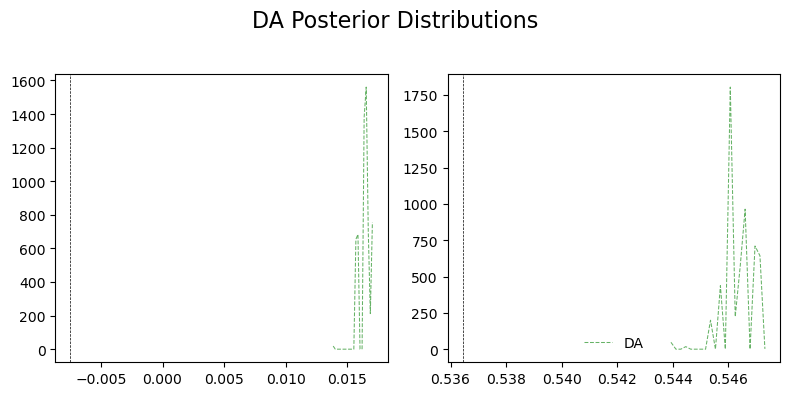

In [29]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 4))  # Adjust figsize for better visualization
fig.suptitle("DA Posterior Distributions", fontsize=16)

# Loop through each subplot
for idx, ax in enumerate(axs.flatten()):
    if idx < samples.shape[1]:  # Check to avoid indexing beyond data dimensions
        bin_centers, counts = histogram_(samples[:, idx],bins=20)
        ax.plot(bin_centers, counts, alpha=0.6, linestyle="--", linewidth=0.75, label = "DA",color = "green")

        ax.axvline(x = np.array(theta).flatten()[idx], color = 'black',linestyle="--", linewidth=0.5)
    else:
        ax.axis("off")  # Turn off axes for extra subplots
# axs[0].set_xlim(-0.02,0.04)
# axs[1].set_xlim(.52,.56)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
plt.legend(frameon = False)
plt.show()

# DeepGaLa

In [9]:
from nv_files.train_nvs import ic_vort_samples,data_vor_set_preparing
from Base.lla import dgala


def get_deepgalerkin_config():
    config = ConfigDict()

    # Training settings
    config.seed = 180

    config.chunks = 16
    config.points_per_chunk = 250
    config.batch_ic = 8500 
 

    # For deep Galerkin
    config.dim_initial_condition = 128
    config.tau = np.sqrt(2)
    config.d = 5

    config.time_domain = 2
    config.NKL =  1
    config.samples_size_initial = 1000
    
    return config

config = get_deepgalerkin_config()

initial_points,w0,theta = ic_vort_samples(config)

batch_size_interior = config.chunks*config.points_per_chunk

dom = torch.tensor([[0, 2 * torch.pi], [0, 2 * torch.pi],[0,config.time_domain]]).to(device)

samples_interior = iter(UniformSampler(dom, batch_size_interior))

batch = next(samples_interior).to(device)

sorted_batch,initial_points_,initial_condition = data_vor_set_preparing(config,batch, 
                                                    initial_points,w0,theta,batch_size_interior,0)

In [10]:
data_trainig = {"data_fit": {"pde":sorted_batch, "initial_conditions":(initial_condition,initial_points_)}, 
                "class_method": {"pde": ["nv_pde"], "initial_conditions":["w"]},
                "outputs": {"pde": ["nvs", "cond"], "initial_conditions": ["w0"]}}

In [11]:
MDNN_dg = torch.load(f"./models/vorticity_MDNN_dg_1.pth")
MDNN_dg.eval()

llp = dgala(MDNN_dg)

In [12]:
llp.fit(data_trainig)

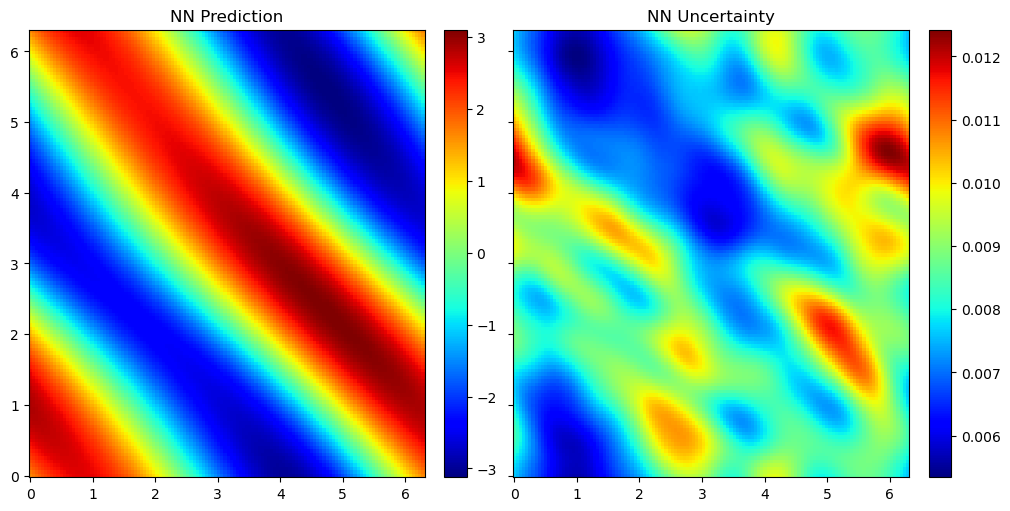

In [21]:
X = torch.linspace(0, 1, 128)*2*torch.pi  # Spatial grid in X direction
Y = torch.linspace(0, 1, 128)*2*torch.pi  # Spatial grid in Y direction
X, Y = torch.meshgrid(X, Y)  # Create meshgrid for X, Y

data_test = torch.hstack((X.reshape(-1,1),Y.reshape(-1,1),2*torch.ones_like(X.reshape(-1,1)))).float()

th1 = theta[:,:,0].reshape(-1,1).T.repeat_interleave(data_test.shape[0], dim=0)

dataset1 = torch.cat((data_test, th1), dim=1)  # Shape (16000, 103)

surg_mu, surg_sigma = llp(dataset1)

surg_mu = surg_mu[:,0].view(-1, 1).detach().numpy()

surg_sigma = surg_sigma[:, 0].view(-1, 1).detach().numpy()

pred_mu = griddata((X.reshape(-1), Y.reshape(-1)), surg_mu.flatten(),(X, Y), method='cubic')
pred_sigma = griddata((X.reshape(-1), Y.reshape(-1)), surg_sigma.flatten(),(X, Y), method='cubic')


fig, axs = plt.subplots(1,2,figsize = (10,5), layout='constrained', sharey=True, sharex=True)

pcm1 = axs[0].pcolormesh(X, Y, pred_mu, cmap='jet')
axs[0].set_title("NN Prediction")
plt.colorbar(pcm1)

pcm = axs[1].pcolormesh(X, Y, pred_sigma, cmap='jet')
axs[1].set_title("NN Uncertainty")
plt.colorbar(pcm)

In [14]:
llp.optimize_marginal_likelihood( max_iter=100)

Iteration 100, Error: 0.01001, neg_marglik: 1001.44946
Maximum iterations (100)reached, sigma : 0.37158918380737305, prior: 2.7205142974853516.


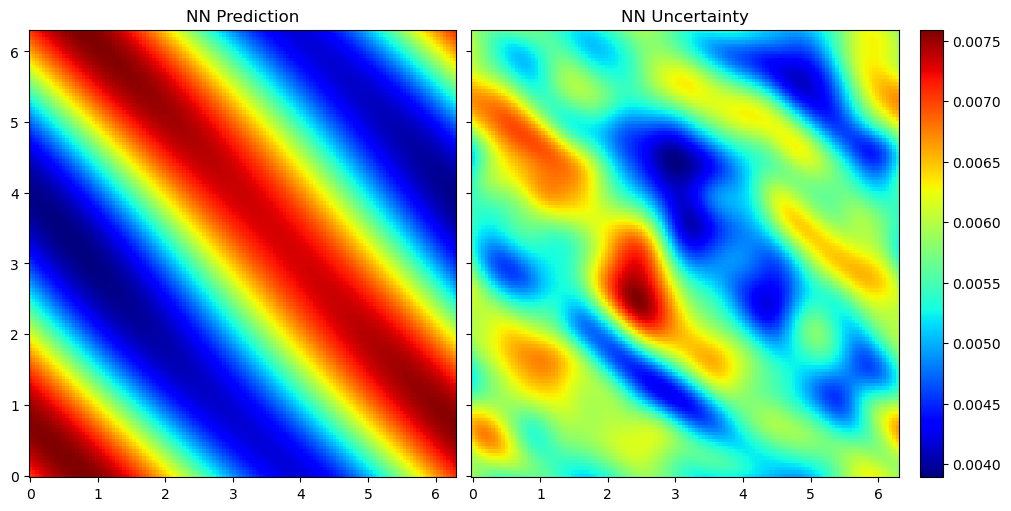

In [20]:
X = torch.linspace(0, 1, 128)*2*torch.pi  # Spatial grid in X direction
Y = torch.linspace(0, 1, 128)*2*torch.pi  # Spatial grid in Y direction
X, Y = torch.meshgrid(X, Y)  # Create meshgrid for X, Y

data_test = torch.hstack((X.reshape(-1,1),Y.reshape(-1,1),2*torch.ones_like(X.reshape(-1,1)))).float()

th1 = theta[:,:,10].reshape(-1,1).T.repeat_interleave(data_test.shape[0], dim=0)

dataset1 = torch.cat((data_test, th1), dim=1)  # Shape (16000, 103)

surg_mu, surg_sigma = llp(dataset1)

surg_mu = surg_mu[:,0].view(-1, 1).detach().numpy()

surg_sigma = surg_sigma[:, 0].view(-1, 1).detach().numpy()

pred_mu = griddata((X.reshape(-1), Y.reshape(-1)), surg_mu.flatten(),(X, Y), method='cubic')
pred_sigma = griddata((X.reshape(-1), Y.reshape(-1)), surg_sigma.flatten(),(X, Y), method='cubic')

fig, axs = plt.subplots(1,2,figsize = (10,5), layout='constrained', sharey=True, sharex=True)

axs[0].pcolormesh(X, Y, pred_mu, cmap='jet')
axs[0].set_title("NN Prediction")

pcm = axs[1].pcolormesh(X, Y, pred_sigma, cmap='jet')
axs[1].set_title("NN Uncertainty")
plt.colorbar(pcm)

In [ ]:
llp.optimize_marginal_likelihood()

# Uncertainty of the NN

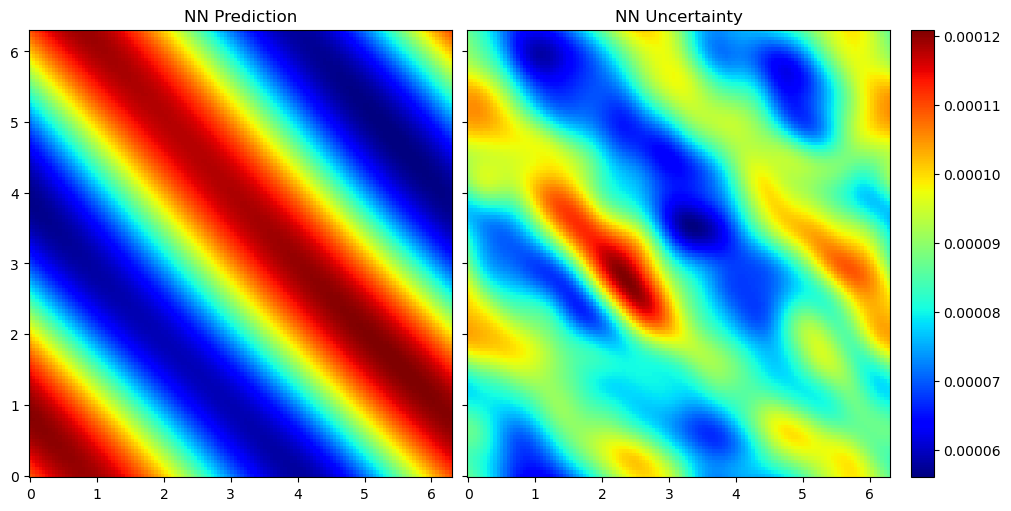

In [ ]:
X = torch.linspace(0, 1, 128)*2*torch.pi  # Spatial grid in X direction
Y = torch.linspace(0, 1, 128)*2*torch.pi  # Spatial grid in Y direction
X, Y = torch.meshgrid(X, Y)  # Create meshgrid for X, Y

data_test = torch.hstack((X.reshape(-1,1),Y.reshape(-1,1),2*torch.ones_like(X.reshape(-1,1)))).float()

th1 = theta[:,:,0].reshape(-1,1).T.repeat_interleave(data_test.shape[0], dim=0)

dataset1 = torch.cat((data_test, th1), dim=1)  # Shape (16000, 103)

surg_mu, surg_sigma = llp(dataset1)

surg_mu = surg_mu[:,0].view(-1, 1).detach().numpy()

surg_sigma = surg_sigma[:, 0].view(-1, 1).detach().numpy()

pred_mu = griddata((X.reshape(-1), Y.reshape(-1)), surg_mu.flatten(),(X, Y), method='cubic')
pred_sigma = griddata((X.reshape(-1), Y.reshape(-1)), surg_sigma.flatten(),(X, Y), method='cubic')


fig, axs = plt.subplots(1,2,figsize = (10,5), layout='constrained', sharey=True, sharex=True)

axs[0].pcolormesh(X, Y, pred_mu, cmap='jet')
axs[0].set_title("NN Prediction")

pcm = axs[1].pcolormesh(X, Y, pred_sigma, cmap='jet')
axs[1].set_title("NN Uncertainty")
plt.colorbar(pcm)

# DeepGaLA MCMC

In [20]:

def dgala_surrogate(surrogate,noisy_obs, valuation_inputs,sig  = np.sqrt(1e-3),device='cpu'):

    # Prior for the parameters theta (assuming 2 parameters)
    theta = pyro.sample("theta", dist.Uniform(-1, 1).expand([2]))

    data_test = torch.cat([valuation_inputs, theta.repeat(valuation_inputs.size(0), 1)], dim=1)

    surg_mu, surg_sigma = surrogate(data_test)

    surg_mu = surg_mu[:,0].view(-1, 1)

    surg_sigma = surg_sigma[:, 0].view(-1, 1)

    sigma = sig ** 2 + surg_sigma

    # Likelihood: Gaussian likelihood with a fixed standard deviation
    y = pyro.sample("obs", dist.Normal(surg_mu, torch.sqrt(sigma)).to_event(1), obs=torch.Tensor(noisy_obs).to(device))

    return y

In [25]:
st = torch.sqrt(torch.tensor(1e-3,dtype=torch.float32)).to(device)

kernel = mcmc.RandomWalkKernel(dgala_surrogate, target_accept_prob=0.234)

mcmc_sampler = mcmc.MCMC(kernel, num_samples=400000, warmup_steps=500)

mcmc_sampler.run(llp,noisy_obs,obs_input)

# Get the results (posterior samples)
samples = mcmc_sampler.get_samples()
samples = samples["theta"].numpy()

np.save(f'./results/lla_MDNN_dg_samples_1.npy', samples)
del kernel, mcmc_sampler, samples

Sample: 100%|██████████| 400500/400500 [78:46:13,  1.41it/s, step size=5.15e-02, acc. prob=0.005]  


# Other

In [ ]:
from data_generator import solve_poisson_fft,compute_velocity,UniformSampler
from Training import compute_loss

numpy_x = np.load("numpy_x.npy")
numpy_y = np.load("numpy_y.npy")
numpy_w = np.load("numpy_w.npy")

X, Y = torch.meshgrid(torch.tensor(numpy_x), torch.tensor(numpy_y),indexing="ij")
dx, dy = X[1, 0] - X[0, 0], Y[0, 1] - Y[0, 0]
w0 = torch.tensor(numpy_w).unsqueeze(-1)

psi = solve_poisson_fft(w0, dx, dy)
u0, v0 = compute_velocity(psi, dx, dy)

initial_points = torch.hstack([X.reshape(-1, 1), Y.reshape(-1, 1), torch.zeros_like(X.reshape(-1, 1))])
initial_condition = torch.hstack([w0.reshape(-1, 1), u0.reshape(-1, 1), v0.reshape(-1, 1)])

dom = torch.tensor([[0, 2 * torch.pi], [0, 2 * torch.pi]]).to(device)

fourier_emb = {"embed_scale" : 1, "embed_dim" :256, "input_dim":3}
period_emb_config = {"period": (1.0, 1.0), "axis": (0, 1)}
reparam = {"type":"weight_fact","mean":0.5,"stddev":0.1}
# Define model, optimizer, scheduler, etc.

loss_fn = torch.nn.MSELoss(reduction ='mean')

# Define model, optimizer, scheduler, etc.
wrf_MDNN_model = WRF_MDNN(num_layers=4, hidden_dim=256, out_dim=2, 
                 input_dim=3,
                 fourier_emb = fourier_emb,
                 reparam=reparam, period_emb=period_emb_config).to(device)

MDNN_model = MDNN(num_layers=4, hidden_dim=256, out_dim=2, 
                 input_dim=(3),fourier_emb = fourier_emb, period_emb = period_emb_config).to(device)

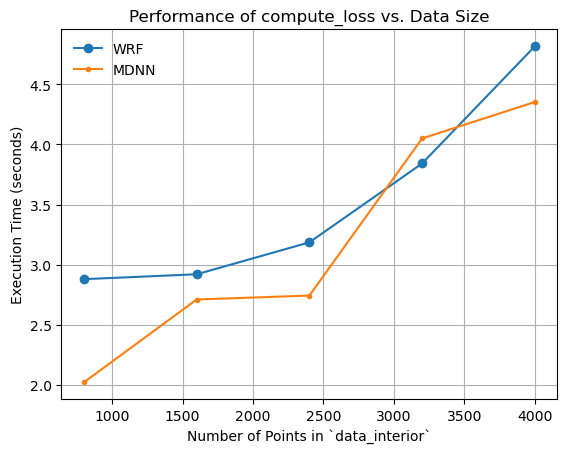

In [18]:
import time
import matplotlib.pyplot as plt

sizes = [16*i for i in range(50,300,50)]  # Varying number of points in `data_interior`
times = {"WRF":[],"MDNN":[]}
models = {"WRF":wrf_MDNN_model,"MDNN":MDNN_model}

for model in models.keys():
    for size in sizes:
        samples_interior = iter(UniformSampler(dom, size))
        timedomain = torch.linspace(0,1,size).reshape(-1, 1)
        batch = next(samples_interior)
        sorted_batch = torch.cat((batch, timedomain), dim=1).to(device)

        start_time = time.time()
        total_loss, _, _ = compute_loss(models[model], loss_fn, sorted_batch, initial_points, initial_condition, [1]*5)
        end_time = time.time()
        times[model].append(end_time - start_time)

# Plot Results
plt.plot(sizes, times["WRF"], marker='o',label = "WRF")
plt.plot(sizes, times["MDNN"], marker='.',label = "MDNN")

plt.xlabel('Number of Points in `data_interior`')
plt.ylabel('Execution Time (seconds)')
plt.title('Performance of compute_loss vs. Data Size')
plt.legend(frameon = False)
plt.grid(True)
plt.show()

In [37]:
import sys
import os

# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import torch
import wandb
import numpy as np
from ml_collections import ConfigDict
from nv_files.train_nvs import train_pinn_nvs
from nv_files.data_generator import solve_poisson_fft,compute_velocity,UniformSampler

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [116]:
def get_deepgalerkin_config():
    config = ConfigDict()

    # Training settings
    config.seed = 108

    config.chunks = 16
    config.points_per_chunk = 1 

    # For deep Galerkin
    config.dim_initial_condition = 100
    config.NKL =  50
    config.samples_size_initial = 15
    config.batch_ic = 10
    return config

In [117]:
from nv_files.train_nvs import ic_vort_samples,data_set_cat,data_vor_set_preparing

config = get_deepgalerkin_config()

WRF_MDNN_dg = torch.load(f"./models/vorticity_MDNN_dg.pth")
WRF_MDNN_dg.eval()

Vorticity(
  (model): MDNN(
    (activation_fn): Tanh()
    (period_layer): PeriodEmbs()
    (fourier_layer): FourierEmbs()
    (u_layer): Linear(in_features=356, out_features=356, bias=True)
    (v_layer): Linear(in_features=356, out_features=356, bias=True)
    (hidden_layers): ModuleList(
      (0-3): 4 x Linear(in_features=356, out_features=356, bias=True)
    )
    (output_layer): Linear(in_features=356, out_features=2, bias=True)
  )
)

In [118]:
# Domain and sampler setup
chunks = 16
points_per_chunk = 10 
time_domain =2

batch_size_interior = chunks*points_per_chunk

initial_points,w0,psi,theta = ic_vort_samples(config)

dom = torch.tensor([[0, 2 * torch.pi], [0, 2 * torch.pi],[0,time_domain]]).to(device)

samples_interior = iter(UniformSampler(dom, batch_size_interior))

batch = next(samples_interior).to(device)

_, indices = batch[:, -1].sort()  # Sort based on the time column

sorted_batch = batch[indices]    # Rearrange rows based on sorted indices


batch = next(samples_interior).to(device)

sorted_batch,initial_points_,initial_condition = data_vor_set_preparing(config,batch, 
                                                    initial_points,w0,psi,theta,batch_size_interior,0)

In [124]:
import torch
import torch.nn as nn
from torch.nn.utils import parameters_to_vector
from torch.distributions.multivariate_normal import _precision_to_scale_tril

from Base.utilities import FeatureExtractor
from copy import deepcopy
from math import sqrt, pi
from  Base.utilities import get_decorated_methods

class dgala(torch.nn.Module):
    def __init__(self, dga, sigma_noise=1., prior_precision=1.,prior_mean=0.):
        super(dgala, self).__init__()

        self.dgala = deepcopy(dga)
        self.model = FeatureExtractor(deepcopy(dga.model), last_layer_name = "output_layer")
        self._device = next(dga.model.parameters()).device
        self.lossfunc = torch.nn.MSELoss(reduction ='sum')
        
        self.loss = 0
        self.temperature = 1
        self.H = None
        self.mean = None
        self.n_params = None
        self.n_data = {key: None for key in self.dgala.lambdas.keys()}

        self._prior_precision = torch.tensor([prior_precision], device=self._device)
        self._prior_mean = torch.tensor([prior_mean], device=self._device)
        self.sigma_noise = torch.tensor(sigma_noise,device=self._device).float()

        if hasattr(self.dgala, "chunks"):
            self.chunks = self.dgala.chunks
    
    @property
    def posterior_precision(self):
        """Diagonal posterior precision \\(p\\)."""
        return self._H_factor * self.H + torch.diag(self.prior_precision_diag)

    @property
    def posterior_covariance(self):
        """Diagonal posterior variance \\(p^{-1}\\).""" 
        post_scale = _precision_to_scale_tril(self.posterior_precision)
        return post_scale @ post_scale.T

    @property
    def _H_factor(self):
        sigma2 = self.sigma_noise.square()
        return 1 / sigma2 / self.temperature
    
    @property
    def prior_precision_diag(self):
        """Obtain the diagonal prior precision \\(p_0\\) constructed from either
        a scalar, layer-wise, or diagonal prior precision."""

        if len(self.prior_precision) == 1:  # scalar
            return self.prior_precision * torch.ones(self.n_params, device=self._device)

        elif len(self.prior_precision) == self.n_params:  # diagonal
            return self.prior_precision
        
    @property
    def scatter(self):
        """Computes the _scatter_, a term of the log marginal likelihood that
        corresponds to L-2 regularization:
        `scatter` = \\((\\theta_{MAP} - \\mu_0)^{T} P_0 (\\theta_{MAP} - \\mu_0) \\)."""

        delta = (self.mean - self.prior_mean)
        return (delta * self.prior_precision_diag) @ delta

    @property
    def log_det_prior_precision(self):
        """Compute log determinant of the prior precision
        \\(\\log \\det P_0\\)"""

        return self.prior_precision_diag.log().sum()

    @property
    def log_det_posterior_precision(self):
        """Compute log determinant of the posterior precision
        \\(\\log \\det P\\) which depends on the subclasses structure
        used for the Hessian approximation."""
        return self.posterior_precision.logdet()

    @property
    def log_det_ratio(self):
        """Compute the log determinant ratio, a part of the log marginal likelihood.
        \\[
            \\log \\frac{\\det P}{\\det P_0} = \\log \\det P - \\log \\det P_0
        \\]log"""
        return self.log_det_posterior_precision - self.log_det_prior_precision
    
    @property
    def log_likelihood(self):
        """Compute log likelihood on the training data after `.fit()` has been called.
        The log likelihood is computed on-demand based on the loss and, for example,
        the observation noise, which makes it differentiable in the latter for
        iterative updates."""

        factor = -self._H_factor
        total_log_likelihood = 0.0

        for key, loss_value in self.loss.items():
            # Compute the normalizer term for Gaussian likelihood
            n_data_key = self.n_data[key]  # Number of data points for this key
            normalizer = n_data_key * torch.log(self.sigma_noise*sqrt(2*pi))

            # Compute log likelihood contribution for this key
            log_likelihood_key = factor * loss_value - normalizer

            # Accumulate total log likelihood
            total_log_likelihood += log_likelihood_key

        return total_log_likelihood
    
    # def log_likelihood(self):
    #     """Compute log likelihood on the training data after `.fit()` has been called.
    #     The log likelihood is computed on-demand based on the loss and, for example,
    #     the observation noise which makes it differentiable in the latter for
    #     iterative updates."""

    #     factor = - self._H_factor
    #     # loss used is just MSE, need to add normalizer for gaussian likelihood
    #     c = self.n_data  * torch.log(self.sigma_noise * sqrt(2 * pi))
    #     return factor * self.loss - c

    def fit(self,fit_data):
        """Fit the local Laplace approximation at the parameters of the model."""
        
        self.class_methods = get_decorated_methods(self.dgala, decorator = "use_laplace")

        assert set(self.class_methods) == set([element for sublist in fit_data["class_method"].values() for element in sublist])

        self.dgala.model.eval()
        params = parameters_to_vector(self.dgala.model.output_layer.parameters()).detach()
        self.n_params = len(params)
        self.prior_precision = self._prior_precision
        self.prior_mean = self._prior_mean
        self._init_H()

        self.mean = parameters_to_vector(self.dgala.model.output_layer.parameters()).detach()

        # Dynamically pass the `data_fit` contents as *args
        data_fit_args = fit_data.get("data_fit", {})
        unpacked_args = []
        for key, value in data_fit_args.items():
            if isinstance(value, tuple):
                # Unpack the tuple and add its elements individually
                unpacked_args.extend(value)
            else:
                # Add non-tuple values directly
                unpacked_args.append(value)

        loss = self.dgala.losses(*unpacked_args,loss_fn = self.lossfunc)

        self.loss = {key:loss.item() for key,loss in loss.items()}

        self.full_Hessian(fit_data)
        
    def _init_H(self):
        self.H = torch.zeros(self.n_params,self.n_params,device=self._device)

    def gradient_outograd(self, y, x):
        grad_p = torch.autograd.grad(outputs=y, 
                                 inputs=x, create_graph=True, allow_unused=True, materialize_grads=True)
        return [grp.detach() for grp in grad_p]
    
    def full_Hessian(self,fit_data, damping_factor=1e-5):
        parameters_ = list(self.dgala.model.output_layer.parameters())
        damping = torch.eye(self.n_params,device=self._device)*damping_factor

        for key,dt_fit in fit_data["data_fit"].items():
            dt_fit = dt_fit[1] if isinstance(dt_fit, tuple) else dt_fit

            for z,clm in enumerate(fit_data["class_method"][key]):
                self.dgala.model.zero_grad()
                fout = getattr(self.dgala, clm)(dt_fit)

                if isinstance(fout, tuple):  # Check if fout is a tuple
                    for i, f_out_indv in enumerate(fout):  # Iterate over fout if it's a tuple
                        indv_h = self.compute_hessian(f_out_indv,parameters_)
                        self. H += (indv_h + damping)*self.dgala.lambdas[fit_data["outputs"][key][i]]
                        self.n_data[fit_data["outputs"][key][i]] = f_out_indv.shape[0]
                else:
                    indv_h = self.compute_hessian(fout,parameters_)
                    self. H += (indv_h + damping)*self.dgala.lambdas[fit_data["outputs"][key][z]]
                    self.n_data[fit_data["outputs"][key][z]] = fout.shape[0]
                    #self.hessian_losses[fit_data["outputs"][key][z]]  = indv_h
                
    def compute_hessian (self,output,parameters_):
        hessian_loss = torch.zeros(self.n_params,self.n_params)
        for fo in output:
            grad_p = self.gradient_outograd(fo,parameters_)
            
            ndim = grad_p[0].shape[0]

            reshaping_grads = [g.reshape(ndim,-1) for g in grad_p]
            # Concatenate along the parameter axis
            jacobian_matrix = torch.cat(reshaping_grads, dim=1).flatten().unsqueeze(0) 

            hessian_loss +=  jacobian_matrix.T @ jacobian_matrix
        return hessian_loss
        

    def __call__(self, x):
        """Compute the posterior predictive on input data `X`."""
        f_mu, f_var = self._glm_predictive_distribution(x)
        return f_mu, f_var


    def _glm_predictive_distribution(self, X):
        Js, f_mu = self.last_layer_jacobians(X)
        f_var = self.functional_variance(Js)
        if f_mu.shape[-1] > 1:
            f_var = torch.diagonal(f_var, dim1 = 1, dim2 = 2)
        return f_mu.detach(), f_var.detach()

    def last_layer_jacobians(self, x):
        """
        Compute Jacobians \\(\\nabla_{\\theta_\\textrm{last}} f(x;\\theta_\\textrm{last})\\) 
        only at current last-layer parameter \\(\\theta_{\\textrm{last}}\\).
        """
        f, phi = self.model.forward_with_features(x)
        bsize = phi.shape[0]
        output_size = f.shape[-1]

        if self.model.last_layer.bias is not None:
            phi = torch.cat([phi, torch.ones(f.shape[0],1).to(self._device)], dim=1)
        # calculate Jacobians using the feature vector 'phi'
        identity = torch.eye(output_size, device=x.device).unsqueeze(0).tile(bsize, 1, 1)
        # Jacobians are batch x output x params
        Js = torch.einsum('kp,kij->kijp', phi, identity).reshape(bsize, output_size, -1)
        # if self.model.last_layer.bias is not None:
        #     Js = torch.cat([Js, identity], dim=2)
        return Js, f.detach()
    

    def functional_variance(self, Js: torch.Tensor) -> torch.Tensor:
        return torch.einsum('ncp,pq,nkq->nck', Js, self.posterior_covariance, Js)
    
  
    def log_marginal_likelihood(self, prior_precision=None, sigma_noise=None):
        """Compute the Laplace approximation to the log marginal likelihood
        """
        # update prior precision (useful when iterating on marglik)
        if prior_precision is not None:
            self.prior_precision = prior_precision

        # update sigma_noise (useful when iterating on marglik)
        if sigma_noise is not None:
            self.sigma_noise = sigma_noise

        return self.log_likelihood - 0.5 * (self.log_det_ratio + self.scatter)
    
    def optimize_marginal_likelihood(self, error_tolerance=1e-3, max_iter=300, lr=1e-2):
        """Optimize the log prior and log sigma by maximizing the marginal likelihood."""

        log_prior_prec = self.prior_precision.log()
        log_prior_prec.requires_grad = True

        log_sigma_noise = self.sigma_noise.log()
        log_sigma_noise.requires_grad = True

        hyper_optimizer = torch.optim.Adam([log_prior_prec, log_sigma_noise], lr=lr)

        error,n_iter = float('inf'),0  # Initialize error

        while error > error_tolerance and n_iter < max_iter:
            prev_log_prior, prev_log_sigma = log_prior_prec.detach().clone(), log_sigma_noise.detach().clone()

            hyper_optimizer.zero_grad()

            # Calculate negative marginal likelihood
            neg_marglik = -self.log_marginal_likelihood(log_prior_prec.exp(), log_sigma_noise.exp())
            neg_marglik.backward(retain_graph=True)

            # Perform optimization step
            hyper_optimizer.step()

            # Calculate the error based on the change in hyperparameters
            error = 0.5 * (torch.abs(log_prior_prec - prev_log_prior) + torch.abs(log_sigma_noise - prev_log_sigma)).item()

            n_iter += 1

            # Optional: log progress for monitoring
            if n_iter % 100 == 0:
                print(f"Iteration {n_iter}, Error: {error:.5f}, neg_marglik: {neg_marglik.item():.5f}")

        self.prior_precision = log_prior_prec.detach().exp()
        self.log_sigma_noise = log_sigma_noise.detach().exp()

        if n_iter == max_iter:
            print(f"Maximum iterations ({max_iter})reached, sigma : {self.sigma_noise.item()}, prior: {self.prior_precision.item()}.")


In [125]:
data_trainig = {"data_fit": {"pde":sorted_batch, "initial_conditions":(initial_condition,initial_points_)}, 
                "class_method": {"pde": ["nv_pde"], "initial_conditions":["w", "phi"]},
                "outputs": {"pde": ["nvs", "cond"], "initial_conditions": ["w0", "phi"]}}

In [126]:
llp = dgala(WRF_MDNN_dg)

In [127]:
llp.fit(data_trainig)

In [128]:
llp.optimize_marginal_likelihood()

Iteration 100, Error: 0.00981, neg_marglik: 400.32901
Iteration 200, Error: 0.00950, neg_marglik: 184.53101
Iteration 300, Error: 0.00922, neg_marglik: -20.87903
Maximum iterations (300)reached, sigma : 0.07592376321554184, prior: 24.561477661132812.


In [129]:
llp(sorted_batch)

(tensor([[-7.8525e-04, -1.4295e-03],
         [-7.1875e-05, -1.1290e-03],
         [ 1.3184e-03, -4.5556e-04],
         [ 8.4711e-04, -4.5906e-04],
         [ 1.9449e-03, -1.7499e-04],
         [-1.6065e-04, -5.4303e-04],
         [ 4.9092e-04, -3.0879e-04],
         [ 7.1498e-04, -5.2889e-04],
         [-1.7187e-04, -6.4360e-04],
         [-4.8559e-05, -5.5032e-04],
         [ 1.3595e-04, -3.9336e-04],
         [-7.0274e-04, -3.0773e-04],
         [-1.5269e-03, -1.7929e-03],
         [ 1.7368e-03, -3.0075e-04],
         [ 9.1698e-04, -6.9850e-04],
         [ 3.0204e-04, -7.8230e-04],
         [-2.1354e-04, -1.0029e-03],
         [-4.4051e-04, -1.2041e-03],
         [ 1.2857e-03, -5.6855e-04],
         [ 1.9769e-03,  6.0509e-04],
         [ 1.0150e-04, -1.3379e-03],
         [ 5.1947e-04, -1.0167e-04],
         [-4.6659e-04, -8.5151e-04],
         [-6.7120e-04, -5.2798e-04],
         [ 1.1328e-03,  1.5782e-04],
         [-3.3185e-04, -1.1538e-03],
         [ 1.9399e-03, -1.7834e-05],
 

In [77]:
import torch
import torch.fft as fft

def log_normal_pdf(x, mode, variance=0.25):
    """Unscaled PDF for a log-normal distribution."""
    mean = torch.log(torch.tensor(mode)) + variance
    logx = torch.log(x)
    return torch.exp(-(mean - logx)**2 / (2 * variance) - logx)

def spectral_density(k, peak_wavenumber, ndim):
    """Spectral density based on a log-normal distribution."""
    return log_normal_pdf(k, mode=peak_wavenumber) / (k ** (ndim - 1))

def divergence_free_projection(velocity, grid_shape):
    """Project velocity field to ensure it's divergence-free using FFT."""
    # Fourier Transform of the velocity components
    u_hat = fft.fftn(velocity[0], dim=(-2, -1))
    v_hat = fft.fftn(velocity[1], dim=(-2, -1))
    kx = torch.fft.fftfreq(grid_shape[0]) * grid_shape[0]
    ky = torch.fft.fftfreq(grid_shape[1]) * grid_shape[1]
    kx, ky = torch.meshgrid(kx, ky, indexing="ij")
    k2 = kx**2 + ky**2
    k2[0, 0] = 1.0  # Avoid division by zero

    # Divergence-free projection in Fourier space
    u_hat_projected = u_hat - (kx * (kx * u_hat + ky * v_hat)) / k2
    v_hat_projected = v_hat - (ky * (kx * u_hat + ky * v_hat)) / k2

    # Inverse Fourier Transform back to real space
    u_projected = fft.ifftn(u_hat_projected, dim=(-2, -1)).real
    v_projected = fft.ifftn(v_hat_projected, dim=(-2, -1)).real

    return torch.stack([u_projected, v_projected])

def compute_vorticity(velocity, grid_shape):
    """Compute the vorticity field from a 2D velocity field."""
    u, v = velocity[0], velocity[1]
    dx = 1.0 / grid_shape[0]
    dy = 1.0 / grid_shape[1]

    # Compute gradients using finite differences with periodic boundary conditions
    du_dy = (torch.roll(u, -1, dims=1) - torch.roll(u, 1, dims=1)) / (2 * dy)
    dv_dx = (torch.roll(v, -1, dims=0) - torch.roll(v, 1, dims=0)) / (2 * dx)

    # Vorticity: dv/dx - du/dy
    vorticity = dv_dx - du_dy
    return vorticity

def filtered_velocity_field(grid_shape,maximum_velocity=1.0,peak_wavenumber=3.0,iterations=3,device="cpu"):
    """Generate a divergence-free velocity field with periodic boundary conditions."""
    ndim = len(grid_shape)

    # Initialize random noise as the velocity field
    velocity = torch.randn((ndim,) + grid_shape, device=device)
    
    # Compute spectral filtering function
    kx = torch.fft.fftfreq(grid_shape[0], d=1.0 / grid_shape[0])
    ky = torch.fft.fftfreq(grid_shape[1], d=1.0 / grid_shape[1])
    kx, ky = torch.meshgrid(kx, ky, indexing="ij")
    k = torch.sqrt(kx**2 + ky**2) + 1e-6  # Add small epsilon to avoid zero division
    filter_spectrum = spectral_density(k, peak_wavenumber, ndim)

    # Filter velocity field in Fourier space
    for i in range(ndim):
        v_hat = fft.fftn(velocity[i], dim=(-2, -1))
        v_hat_filtered = v_hat * filter_spectrum
        velocity[i] = fft.ifftn(v_hat_filtered, dim=(-2, -1)).real

    # Iterative projection and normalization
    for _ in range(iterations):
        # Ensure divergence-free condition
        velocity = divergence_free_projection(velocity, grid_shape)

        # Normalize to maximum velocity
        max_speed = torch.linalg.norm(velocity, dim=0).max()
        velocity *= (maximum_velocity / max_speed)


    return velocity

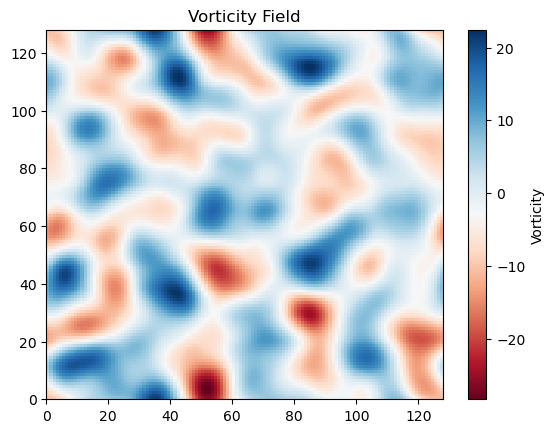

In [139]:
# Define grid and parameters
grid_shape = (128, 128)  # Grid size
device = "cuda" if torch.cuda.is_available() else "cpu"

# Generate divergence-free velocity field
velocity_field = filtered_velocity_field(grid_shape=grid_shape,peak_wavenumber=3.0,device=device)

# Compute vorticity
vorticity_field = compute_vorticity(velocity_field, grid_shape)

# Visualize vorticity
import matplotlib.pyplot as plt
plt.pcolormesh(vorticity_field.cpu().numpy(), cmap="RdBu")
plt.colorbar(label="Vorticity")
plt.title("Vorticity Field")
plt.show()


In [135]:
solver = VorticitySolver2D(N=128, L=1, T=2.0, nu=1e-2, dt=5e-4,num_sol=200, method='CN')

results = solver.run_simulation( vorticity_field.cpu().numpy())

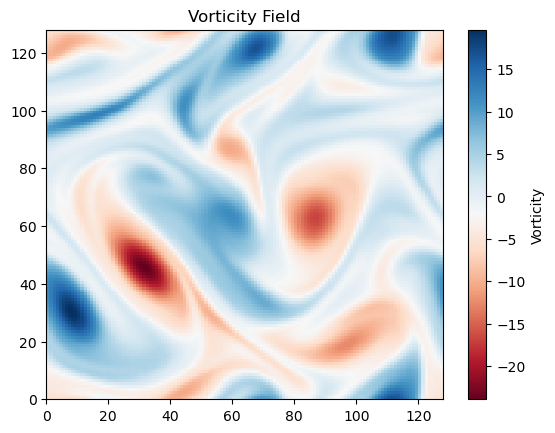

In [136]:
plt.pcolormesh(results[-3], cmap="RdBu")
plt.colorbar(label="Vorticity")
plt.title("Vorticity Field")
plt.show()

In [255]:

dom = torch.tensor([[0, 2 * torch.pi], [0, 2 * torch.pi],[0,config.time_domain]]).to(device)
samples_interior = iter(UniformSampler(dom, batch_size_interior))
batch = next(samples_interior).to(device)

#def initial_conditions_samples(config):
X = torch.linspace(0, 1, 128)*2*torch.pi  # Spatial grid in X direction
Y = torch.linspace(0, 1, 128)*2*torch.pi  # Spatial grid in Y direction
X, Y = torch.meshgrid(X, Y, indexing='ij' )  # Create meshgrid for X, Y

dx, dy = X[1, 0] - X[0, 0], Y[0, 1] - Y[0, 0]

torch.manual_seed(config.seed)  # Replace 42 with your desired seed value

# Generate uniformly distributed values for `theta` in the range [-1, 1]
theta = torch.rand(50, 2, 10) * 2 - 1  # Uniform(-1, 1)

w0 = omega0_samples_torch(X, Y, theta)
    
"""Compute initial points and conditions."""
psi = solve_poisson_fft(w0, dx, dy)
u0, v0 = compute_velocity(psi, dx, dy)

initial_points = torch.hstack([X.reshape(-1, 1), Y.reshape(-1, 1), torch.zeros_like(X.reshape(-1, 1))])

w0,u0,v0 = w0.reshape(-1, 10),u0.reshape(-1, 10),v0.reshape(-1,10)

    #return initial_points,w0,u0,v0,theta

In [230]:
# Function to select indices
def sample_indices_ic(size, N, seed):
    with torch.random.fork_rng():  # Isolate RNG
        torch.manual_seed(seed)  # Set the seed
        indices = torch.randperm(size)[:N]  # Generate N random indices
    return indices


def data_set_preparing(data_set, theta):
    theta = theta.view(-1,theta.shape[-1])  # Flatten and repeat

    # Repeat `ini` for the number of columns in `theta`
    num_cols = theta.shape[1]
    data_set_r = data_set.repeat(num_cols, 1)  # Shape (16000, 3)

    # Repeat each column of `theta` to match rows in `ini`
    theta_ = theta.T.repeat_interleave(data_set.shape[0], dim=0)  # Shape (16000, 100)

    # Concatenate along the last dimension
    result = torch.cat((data_set_r, theta_), dim=1)  # Shape (16000, 103)

    return result

In [256]:
indices = sample_indices_ic(initial_points.shape[0], batch_size_interior, 0)

In [260]:
initial_points.shape

torch.Size([16384, 3])

In [258]:
data_set_preparing(initial_points,theta).shape

torch.Size([163840, 103])

In [165]:
initial_points = initial_points[indices]
w0,u0,v0 = w0[indices],u0[indices],v0[indices]

In [225]:
w0.T.reshape(-1,1)[1600:3200]

tensor([[ 0.0004],
        [ 0.0002],
        [-0.0003],
        ...,
        [-0.0007],
        [-0.0002],
        [-0.0007]])

In [238]:
theta_ = theta.view(-1,10)  # Flatten and repeat


In [246]:
theta_[:,1]

tensor([-0.5041, -0.4025, -0.6870, -0.9141, -0.8277,  0.6730,  0.0581, -0.5816,
        -0.3704, -0.2889, -0.8639,  0.9633, -0.7589, -0.8119, -0.3188, -0.7835,
         0.3715,  0.2083,  0.2123, -0.8551, -0.0599, -0.5181, -0.2317,  0.2546,
         0.1139,  0.8640,  0.5637,  0.3541,  0.3095, -0.2369,  0.3488,  0.9168,
         0.5448,  0.6083, -0.8641, -0.4588, -0.8174, -0.7772, -0.2332, -0.9895,
         0.6839, -0.1150,  0.8023,  0.1549, -0.1030,  0.3800,  0.5451, -0.8227,
         0.4758,  0.5159,  0.9765,  0.1207,  0.4999, -0.9535,  0.1491,  0.4170,
         0.3912,  0.2888, -0.1700,  0.7819,  0.2301,  0.5505,  0.8991, -0.8501,
        -0.4625,  0.1757,  0.8193, -0.1986,  0.6951,  0.4819,  0.6252, -0.7215,
        -0.3559,  0.7240,  0.9286,  0.4301,  0.3605, -0.7598, -0.6951,  0.7993,
         0.7495, -0.0530, -0.0406, -0.9434, -0.9795, -0.8218, -0.2715, -0.0793,
         0.7196, -0.4466,  0.9315,  0.0378,  0.4360, -0.4123,  0.0607, -0.2469,
        -0.7561,  0.3959,  0.1612, -0.19

In [250]:
batch

tensor([[0.1821, 2.5252, 0.5197],
        [2.3037, 0.3663, 1.4013],
        [0.3255, 2.9414, 1.3476],
        ...,
        [0.5210, 3.5817, 1.5083],
        [0.2315, 2.4043, 1.7776],
        [3.6619, 3.3007, 1.4168]])

In [247]:
zz = data_set_preparing(batch,theta)

In [252]:
zz[1600,:]

tensor([ 0.1821,  2.5252,  0.5197, -0.5041, -0.4025, -0.6870, -0.9141, -0.8277,
         0.6730,  0.0581, -0.5816, -0.3704, -0.2889, -0.8639,  0.9633, -0.7589,
        -0.8119, -0.3188, -0.7835,  0.3715,  0.2083,  0.2123, -0.8551, -0.0599,
        -0.5181, -0.2317,  0.2546,  0.1139,  0.8640,  0.5637,  0.3541,  0.3095,
        -0.2369,  0.3488,  0.9168,  0.5448,  0.6083, -0.8641, -0.4588, -0.8174,
        -0.7772, -0.2332, -0.9895,  0.6839, -0.1150,  0.8023,  0.1549, -0.1030,
         0.3800,  0.5451, -0.8227,  0.4758,  0.5159,  0.9765,  0.1207,  0.4999,
        -0.9535,  0.1491,  0.4170,  0.3912,  0.2888, -0.1700,  0.7819,  0.2301,
         0.5505,  0.8991, -0.8501, -0.4625,  0.1757,  0.8193, -0.1986,  0.6951,
         0.4819,  0.6252, -0.7215, -0.3559,  0.7240,  0.9286,  0.4301,  0.3605,
        -0.7598, -0.6951,  0.7993,  0.7495, -0.0530, -0.0406, -0.9434, -0.9795,
        -0.8218, -0.2715, -0.0793,  0.7196, -0.4466,  0.9315,  0.0378,  0.4360,
        -0.4123,  0.0607, -0.2469, -0.75

In [181]:
theta.shape

theta_ = theta.view(-1,10)  # Flatten and repeat


In [192]:
# Repeat `ini` for the number of columns in `theta`
num_cols = theta_.shape[1]
repeated_ini = initial_points.repeat(num_cols, 1)  # Shape (16000, 3)

# Repeat each column of `theta` to match rows in `ini`
theta_expanded = theta_.T.repeat_interleave(initial_points.shape[0], dim=0)  # Shape (16000, 100)

# Concatenate along the last dimension
result = torch.cat((repeated_ini, theta_expanded), dim=1)  # Shape (16000, 103)

print(result.shape)

torch.Size([16000, 103])
